In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/studentcnn/pytorch/default/1/model (4).pth


In [2]:
!pip install detectors -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.8/616.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 5.7 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader


In [4]:
import torch,timm,detectors
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn import KLDivLoss
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128 , shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model = timm.create_model("resnet34_cifar10", pretrained=True).to(device)


100%|██████████| 170M/170M [00:11<00:00, 14.6MB/s]
Downloading: "https://huggingface.co/edadaltocg/resnet34_cifar10/resolve/main/pytorch_model.bin" to /root/.cache/torch/hub/checkpoints/resnet34_cifar10.pth
100%|██████████| 81.3M/81.3M [00:00<00:00, 254MB/s]


In [5]:

cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split into validation and test sets (50/50)
val_size = len(cifar10_test) // 2
test_size = len(cifar10_test) - val_size
val_set, final_test_set = random_split(cifar10_test, [val_size, test_size])

val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(final_test_set, batch_size=128, shuffle=False)


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class StudentCNN(nn.Module):
    def __init__(self):
        super(StudentCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # After 3 poolings: 32 → 16 → 8 → 4
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 32x32 → 16x16
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 16x16 → 8x8
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 8x8 → 4x4
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)


In [7]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [8]:
def train_with_kl_and_ce(student_model, teacher_model, loader, optimizer, epochs=200, temperature=2, alpha=0.7):
    kl_loss = nn.KLDivLoss(reduction='batchmean')
    ce_loss = nn.CrossEntropyLoss()
    student_model.train()
    teacher_model.eval()
    best_val_acc = 0
    patience = 20
    epochs_no_improve = 0
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            with torch.no_grad():
                teacher_logits = teacher_model(images)
                teacher_probs = F.softmax(teacher_logits / temperature, dim=1)
              
            optimizer.zero_grad()
            student_logits = student_model(images)

            # KL Divergence Loss
            student_log_probs = F.log_softmax(student_logits / temperature, dim=1)

            loss_kl = kl_loss(student_log_probs, teacher_probs) * (temperature ** 2)

            # Cross-Entropy Loss
            loss_ce = ce_loss(student_logits, labels)

            # Combined Loss
            loss = alpha * loss_kl + (1 - alpha) * loss_ce

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        val_acc = evaluate(student_model, val_loader)
        
        if val_acc > best_val_acc:
                best_val_acc = val_acc
                epochs_no_improve = 0
                # Save best model
                torch.save(student_model.state_dict(), f"best_student_model_{temperature}_{alpha*10}.pth")
                #print(f"Best Modal Epoch {epoch+1}, Total Loss: {total_loss:.4f} Validation :{val_acc}")
        else:
                epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
                #print(f"Early stopping at epoch {epoch+1}")
                break
        #print(f"Epoch {epoch+1}, Total Loss: {total_loss:.4f} Validation :{val_acc}")
    return best_val_acc

In [9]:


results = []


temperature=list(range(2,10))
alpha=[0.5,0.6,0.7,0.8,0.9,1]
for t in temperature:
    for a in alpha:
        student_model_kl = StudentCNN()
        student_model_kl.to(device)
        optimizer_kl =torch.optim.Adam(student_model_kl.parameters(), lr=1e-3, weight_decay=5e-4)

        print(f"Using temp: {t} and alpha: {a}")
        best_val_acc = train_with_kl_and_ce(student_model_kl, teacher_model, train_loader, optimizer_kl,t,a)
        results.append((t, a, best_val_acc))


Using temp: 2 and alpha: 0.5
Using temp: 2 and alpha: 0.6
Using temp: 2 and alpha: 0.7
Using temp: 2 and alpha: 0.8
Using temp: 2 and alpha: 0.9
Using temp: 2 and alpha: 1
Using temp: 3 and alpha: 0.5
Using temp: 3 and alpha: 0.6
Using temp: 3 and alpha: 0.7
Using temp: 3 and alpha: 0.8
Using temp: 3 and alpha: 0.9
Using temp: 3 and alpha: 1
Using temp: 4 and alpha: 0.5
Using temp: 4 and alpha: 0.6
Using temp: 4 and alpha: 0.7
Using temp: 4 and alpha: 0.8
Using temp: 4 and alpha: 0.9
Using temp: 4 and alpha: 1
Using temp: 5 and alpha: 0.5
Using temp: 5 and alpha: 0.6
Using temp: 5 and alpha: 0.7
Using temp: 5 and alpha: 0.8
Using temp: 5 and alpha: 0.9
Using temp: 5 and alpha: 1
Using temp: 6 and alpha: 0.5
Using temp: 6 and alpha: 0.6
Using temp: 6 and alpha: 0.7
Using temp: 6 and alpha: 0.8
Using temp: 6 and alpha: 0.9
Using temp: 6 and alpha: 1
Using temp: 7 and alpha: 0.5
Using temp: 7 and alpha: 0.6
Using temp: 7 and alpha: 0.7
Using temp: 7 and alpha: 0.8
Using temp: 7 and alpha:

In [10]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [11]:

with open("/kaggle/working/distillation_grid_search_results.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Temperature", "Alpha", "Best_Validation_Accuracy"])
    writer.writerows(results)



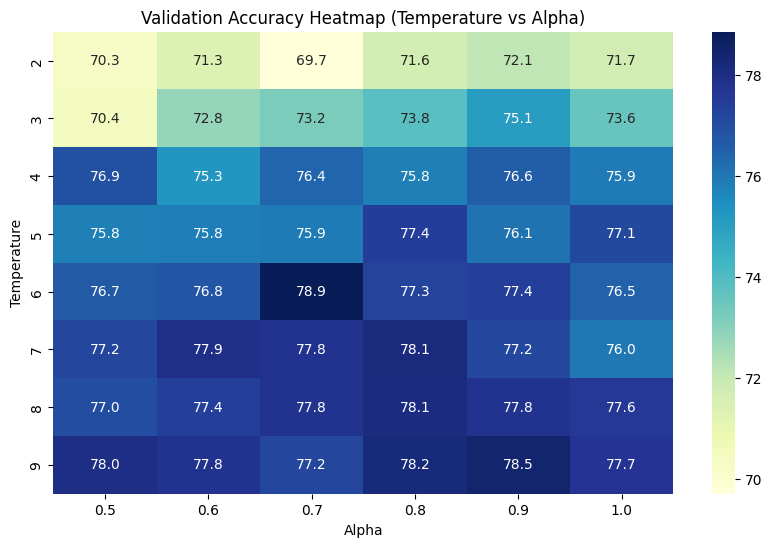

In [12]:
# Plot heatmap
df = pd.DataFrame(results, columns=["Temperature", "Alpha", "Best_Validation_Accuracy"])
heatmap_data = df.pivot(index="Temperature", columns="Alpha", values="Best_Validation_Accuracy")

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Validation Accuracy Heatmap (Temperature vs Alpha)")
plt.savefig("distillation_heatmap.png")
plt.show()
